In [1]:
from PIL import Image
from tqdm import tqdm
from pathlib import Path
import time
import os  
import matplotlib.pyplot as plt 

import torchaudio
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Data Check

In [2]:
def CheckDataset(path=None, train=False, filetype=None):
    print("############################################")
    if train==True:
        print("Train ("+filetype+")")
    else:
        print("Test ("+filetype+")")
    list = os.listdir(path)
    Total=0
    for i in list:
        temp = os.listdir(os.path.join(path,i))
        print(i+": "+str(len(temp)))
        Total += len(temp)
    print("Total: ", Total)    
    print("############################################")    

In [3]:
CheckDataset("C:/Users/User/GCT634 Final/Sub-URMP/img/train", True, 'img')

############################################
Train (img)
bassoon: 1735
cello: 9800
clarinet: 8125
double_bass: 1270
flute: 5690
horn: 5540
oboe: 4505
sax: 7615
trombone: 8690
trumpet: 1015
tuba: 3285
viola: 6530
violin: 7430
Total:  71230
############################################


In [4]:
CheckDataset("C:/Users/User/GCT634 Final/Sub-URMP/chunk/train", True, 'wav')

############################################
Train (wav)
bassoon: 1735
cello: 9800
clarinet: 8125
double_bass: 1270
flute: 5690
horn: 5540
oboe: 4505
sax: 7615
trombone: 8690
trumpet: 1015
tuba: 3285
viola: 6530
violin: 7430
Total:  71230
############################################


In [5]:
CheckDataset("C:/Users/User/GCT634 Final/Sub-URMP/img/test", False, 'img')

############################################
Test (img)
bassoon: 390
cello: 1030
clarinet: 945
double_bass: 1180
flute: 925
horn: 525
oboe: 390
sax: 910
trombone: 805
trumpet: 520
tuba: 525
viola: 485
violin: 945
Total:  9575
############################################


In [6]:
CheckDataset("C:/Users/User/GCT634 Final/Sub-URMP/chunk/test", False, 'img')

############################################
Test (img)
bassoon: 390
cello: 1030
clarinet: 945
double_bass: 1180
flute: 925
horn: 525
oboe: 390
sax: 910
trombone: 805
trumpet: 520
tuba: 525
viola: 485
violin: 945
Total:  9575
############################################


# Change File name

In [7]:
def ChangeFileName(path, filetype):
    j = os.listdir(path)
    for instrumentclass in j:
        idx = 1
        i = os.listdir(os.path.join(path,instrumentclass))
        renamepath = os.path.join(path,instrumentclass)
        for eachdata in i:
            #print(os.path.join(renamepath, eachdata))
            os.rename(os.path.join(renamepath, eachdata), os.path.join(renamepath, str(idx)+'.'+filetype))
            idx += 1

In [8]:
# GCT634 Final --> your directory name
'''
ChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/chunk/train', 'wav')
ChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/chunk/test', 'wav')
ChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/img/train', 'jpg')
ChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/img/test', 'jpg')
'''

"\nChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/chunk/train', 'wav')\nChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/chunk/test', 'wav')\nChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/img/train', 'jpg')\nChangeFileName('C:/Users/User/GCT634 Final/Sub-URMP/img/test', 'jpg')\n"

# Dataset and DataLoader

In [9]:
class SubURMP(Dataset):
    """Customized SubURMP Dataset.
    datset
        `-- SubURMP
            |-- img
                |-- train
                    |-- bassoon
                        |-- 0001.jpg
                        |-- ...
                        `-- 1735.jpg
                    |-- ...
                    `-- violin
                        |-- 0001.jpg
                        |-- ...
                        `-- 7430.jpg
                `-- test
                    |-- bassoon
                        |-- 0001.jpg
                        |-- ...
                        `-- 0390.jpg
                    |-- ...
                    `-- violin
                        |-- 0001.jpg
                        |-- ...
                        `-- 0945.jpg
            |-- chunk
                |-- train
                    |-- bassoon
                        |-- 0001.wav
                        |-- ...
                        `-- 1735.wav
                    |-- ...
                    `-- violin
                        |-- 0001.wav
                        |-- ...
                        `-- 7430.wav
                `-- test
                    |-- bassoon
                        |-- 0001.wav
                        |-- ...
                        `-- 0390.wav
                    |-- ...
                    `-- violin
                        |-- 0001.wav
                        |-- ...
                        `-- 0945.wav
                # Train
                bassoon:1735
                cello:9800
                clarinet:8125
                double_bass:1270
                flute:5690
                horn:5540
                oboe:4505
                sax:7615
                trombone:8690
                trumpet:1015
                tuba:3285
                viola:6530
                violin:7430 

                # Test
                bassoon:390
                cello:1030
                clarinet:945
                double_bass:1180
                flute:925
                horn:525
                oboe:390
                sax:910
                trombone:805
                trumpet:520
                tuba:525
                viola:485
                violin:945    
    """
 
    def __init__(self, root, train=True, imgtransform=None, chunktransform=None):
        super(SubURMP, self).__init__()
        self.root = root
        self.imgtransform = imgtransform
        self.chunktransform = chunktransform
        self.instruments = ['bassoon', 'cello', 'clarinet', 'double_bass', 'flute', 'horn', 'oboe', 'sax', 'trombone', 'trumpet', 'tuba', 'viola', 'violin']
        self.how_many_train = [1735, 9800, 8125, 1270, 5690, 5540, 4505, 7615, 8690, 1015, 3285, 6530, 7430]
        self.how_many_test = [390, 1030, 945, 1180, 925, 525, 390, 910, 805, 520, 525, 485, 945]
        
        if train==True:
          dummy_img_paths = [self.root+'Sub-URMP/img/train/'+self.instruments[i]+'/'+str(j+1)+ '.jpg' for i in range(len(self.instruments)) for j in range(self.how_many_train[i])]
          dummy_chunk_paths = [self.root+'Sub-URMP/chunk/train/'+self.instruments[i]+'/'+str(j+1)+ '.wav' for i in range(len(self.instruments)) for j in range(self.how_many_train[i])]
        else:
          dummy_img_paths = [self.root+'Sub-URMP/img/test/'+self.instruments[i]+'/'+str(j+1)+ '.jpg' for i in range(len(self.instruments)) for j in range(self.how_many_test[i])]
          dummy_chunk_paths = [self.root+'Sub-URMP/chunk/test/'+self.instruments[i]+'/'+str(j+1)+ '.wav' for i in range(len(self.instruments)) for j in range(self.how_many_test[i])]
        self.img_paths = dummy_img_paths
        self.chunk_paths = dummy_chunk_paths
        
        assert isinstance(self.img_paths, list), 'Wrong type. self.paths should be list.'
        if train is True:
            assert len(self.img_paths) == 71230, 'There are 71,230 train images, but you have gathered %d image paths' % len(self.img_paths)
        else:
            assert len(self.img_paths) == 9575, 'There are 9,575 test images, but you have gathered %d image paths' % len(self.img_paths)
        
    def __getitem__(self, idx):        
        img_path = self.img_paths[idx]
        chunk_path = self.chunk_paths[idx]
        class_label = (self.instruments).index(img_path.split('/')[7])
        label = torch.tensor(class_label).long()
        
        # img: (1080, 1920) -> (256, 256)
        image = Image.open(img_path)
        if self.imgtransform is not None:
            image = self.imgtransform(image) 
       
        # wav: sr 44.1KHz, 16 bits, stereo
        chunk, sr = torchaudio.load(chunk_path)
        if self.chunktransform is not None:
            lms = self.chunktransform(chunk[0])                 
        
        return image, lms, label
    
    def __len__(self):
        return len(self.img_paths)

num data: 71230
image shape: torch.Size([3, 256, 256]) | type: torch.float32
chunk shape: torch.Size([128, 44]) | type: torch.float32
label: tensor(1)


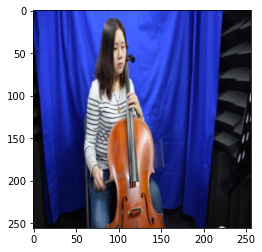

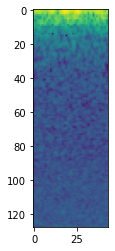

In [10]:
data_dir = 'C:/Users/User/GCT634 Final/'
train = True
imgtransform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor()
    ])
chunktransform = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_fft=2048, hop_length=512, f_min=0.0, f_max=8000.0, n_mels=128),
    torchaudio.transforms.AmplitudeToDB()
    )

dset = SubURMP(data_dir, train, imgtransform, chunktransform)
print('num data:', len(dset))
image_temp, lms_temp, label_temp = dset[1735]
print('image shape:', image_temp.shape, '| type:', image_temp.dtype)
print('chunk shape:', lms_temp.shape, '| type:', lms_temp.dtype)
print('label:', label_temp) 

plt.figure()
plt.imshow(image_temp.permute(1, 2, 0))

plt.figure()
plt.imshow(lms_temp)

In [11]:
from torch.utils.data.dataset import random_split
def get_dataloader(arg):
    imgtransform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((256,256)),
        torchvision.transforms.ToTensor(),
        ])    
    chunktransform = nn.Sequential(
        torchaudio.transforms.MelSpectrogram(sample_rate=44100, n_fft=2048, hop_length=512, f_min=0.0, f_max=8000.0, n_mels=128),
        torchaudio.transforms.AmplitudeToDB()
        )    
    train_dataset = SubURMP(args.dataroot, train=True, imgtransform=imgtransform, chunktransform=chunktransform)    
    train_dataset, valid_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.80), len(train_dataset)-int(len(train_dataset) * 0.80)])
    test_dataset = SubURMP(args.dataroot, train=False, imgtransform=imgtransform, chunktransform=chunktransform)
    
    train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=True, drop_last=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=False)

    print("# of train_dataset:", len(train_dataset))
    print("# of valid_dataset:", len(valid_dataset))
    print("# of test_dataset: ", len(test_dataset))  
    
    return train_dataloader, valid_dataloader, test_dataloader

# Train / Test Pipeline

In [12]:
from easydict import EasyDict as edict

args = edict()

args.name = 'baseline'                  
args.resume = False                  
args.ckpt_dir = 'ckpts'              
args.ckpt_reload = '10'              
args.gpu = True                      

# data options
args.dataroot = 'C:/Users/User/GCT634 Final/' 
args.batch_size = 16              

# training options
args.lr = 0.001                   
args.epoch = 50                   

# tensorboard options
args.tensorboard = True           
args.log_dir = 'logs'             
args.log_iter = 100               

In [13]:
train_dataloader, valid_dataloader, test_dataloader = get_dataloader(args)

# of train_dataset: 56984
# of valid_dataset: 14246
# of test_dataset:  9575


In [14]:
def train(args):

    device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

    for image, lms, label in train_dataloader:
        image = image.to(device) 
        lms = lms.to(device)
        label = label.to(device)
        print("image.shape:",image.shape)
        print("chunk.shape:",lms.shape)
        print("label.shape:",label.shape)
        break
        
    for image, lms, label in valid_dataloader:
        image = image.to(device) 
        lms = lms.to(device)
        label = label.to(device)
        print("image.shape:",image.shape)
        print("chunk.shape:",lms.shape)
        print("label.shape:",label.shape)
        break     

In [15]:
train(args)

image.shape: torch.Size([16, 3, 256, 256])
chunk.shape: torch.Size([16, 128, 44])
label.shape: torch.Size([16])
image.shape: torch.Size([16, 3, 256, 256])
chunk.shape: torch.Size([16, 128, 44])
label.shape: torch.Size([16])
